[nltk_data] Downloading package punkt to
[nltk_data]     /Users/m.sushanthreddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/m.sushanthreddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/m.sushanthreddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


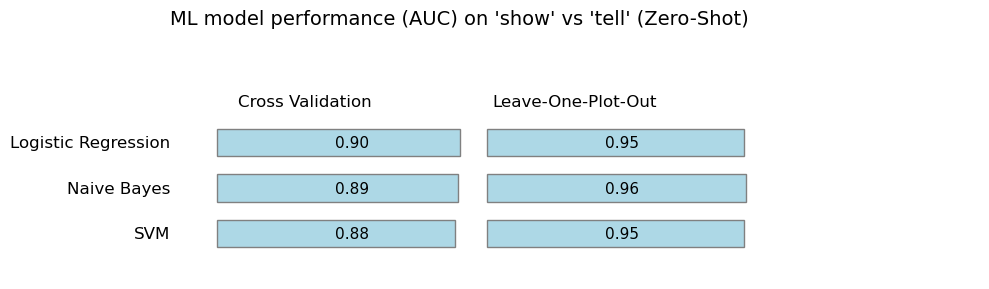

In [90]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df = pd.read_csv("/Users/m.sushanthreddy/Downloads/data_stories_one_shot.csv") 

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['processed'] = df['Sentence'].apply(preprocess)

df = df[df['Stage'].isin([1, 2, 3])].dropna(subset=['processed', 'Plot_Name'])

df['label'] = df['Stage'].apply(lambda x: 0 if x == 1 else 1)

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['processed'])
y = df['label'].values
groups = df['Plot_Name'].values

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = pd.DataFrame(index=models.keys(), columns=['Cross Validation', 'Leave-One-Plot-Out'])

for name, model in models.items():
    aucs = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    results.loc[name, 'Cross Validation'] = np.mean(aucs)

logo = LeaveOneGroupOut()
for name, model in models.items():
    aucs = []
    for train_idx, test_idx in logo.split(X, y, groups):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict_proba(X[test_idx])[:, 1]
        if len(np.unique(y[test_idx])) > 1:
            aucs.append(roc_auc_score(y[test_idx], y_pred))
    results.loc[name, 'Leave-One-Plot-Out'] = np.mean(aucs)

results = results.astype(float).round(2)
 

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

col_labels = results.columns.tolist()
row_labels = results.index.tolist()
cell_values = results.values

n_rows, n_cols = cell_values.shape
bar_color = '#add8e6'

cell_height = 0.5
cell_width = 2

for col_idx, label in enumerate(col_labels):
    ax.text((col_idx + 1) * cell_width - 1, (n_rows + 0.5) * cell_height + 0.2,
            label, ha='center', va='center', fontsize=12)

for row_idx, row_label in enumerate(row_labels):
    y = (n_rows - row_idx) * cell_height
    ax.text(0, y, row_label, ha='right', va='center', fontsize=12)

    for col_idx in range(n_cols):
        x = (col_idx + 1) * cell_width - 0.65
        val = cell_values[row_idx, col_idx]

        bar_length = val * cell_width 
        ax.barh(y=y, width=bar_length, height=cell_height * 0.6,
                left=x - cell_width / 2, color=bar_color, edgecolor='gray')

        ax.text(x, y, f"{val:.2f}", ha='center', va='center', fontsize=11, color='black')
print()
print()
plt.title("ML model performance (AUC) on 'show' vs 'tell' (Zero-Shot)", fontsize=14, pad=20, loc ='left')
plt.xlim(0, (n_cols + 1) * cell_width)
plt.ylim(0, (n_rows + 2) * cell_height)
plt.tight_layout()
plt.show()
